### Project: Stock Price Predictions

#### Description: I pick 8 stocks of US energy companies, using previous stock price and LSTM to predict the future price.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, SimpleRNN, Dropout, Dense, Activation, Reshape, MaxPooling1D
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# Loading stock data for training, validation, and testing
def load_stock_data(filename):
    df = pd.read_csv(filename, usecols=["Date", "Close"])
    df['Date'] = pd.to_datetime(df['Date'])
    return df

### Data loading and exploration

In [4]:
# Load and plot data
training_files = ['./xom.us.txt', './cvx.us.txt', './duk.us.txt', './nee.us.txt']
validation_files = ['./rds-b.us.txt', './aep.us.txt']
testing_files = ['./oxy.us.txt', './psx.us.txt']

train_data = [load_stock_data(f) for f in training_files]
valid_data = [load_stock_data(f) for f in validation_files]
test_data = [load_stock_data(f) for f in testing_files]

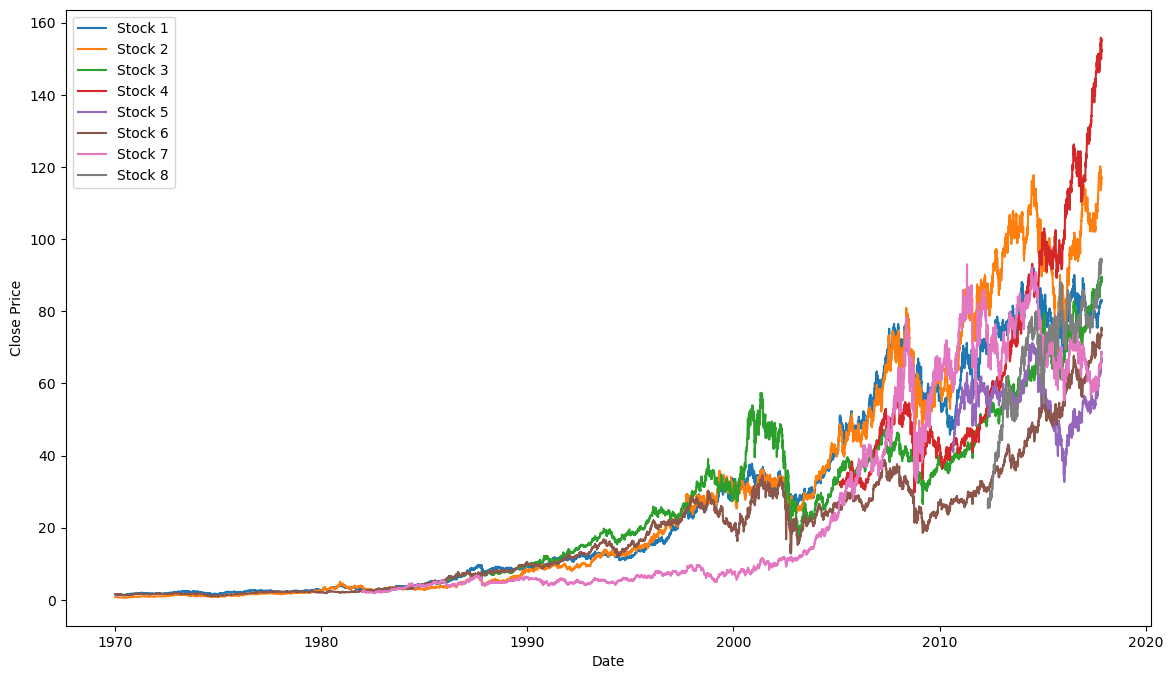

In [5]:
# Plotting closing prices
plt.figure(figsize=(14, 8))
for i, stock in enumerate(train_data + valid_data + test_data):
    plt.plot(stock['Date'], stock['Close'], label=f"Stock {i+1}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

## Preparing the Data for Time Series Prediction

In [6]:
def create_sequences(data, lookback=10):
    X, y = [], []
    for i in range(len(data) - lookback - 2):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback+2])  # Predict two days ahead
    return np.array(X), np.array(y)

In [7]:
# Prepare and scale data
scaler = MinMaxScaler()

def prepare_data(stock_dfs, lookback=10):
    X, y = [], []
    for df in stock_dfs:
        scaled_close = scaler.fit_transform(df['Close'].values.reshape(-1, 1)).flatten()
        X_stock, y_stock = create_sequences(scaled_close, lookback)
        X.append(X_stock)
        y.append(y_stock)
    return np.concatenate(X), np.concatenate(y)

lookback = 10
X_train, y_train = prepare_data(train_data, lookback)
X_valid, y_valid = prepare_data(valid_data, lookback)
X_test, y_test = prepare_data(test_data, lookback)

In [8]:
# Reshape for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Model Building, Training, and Validation

In [9]:
def build_model():
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(lookback, 1)),
        SimpleRNN(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for price prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [10]:
# Train and validate model
model = build_model()
history = model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# Predict and evaluate on validation data
y_valid_pred = model.predict(X_valid)

Epoch 1/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0072
Epoch 2/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0022
Epoch 3/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0020
Epoch 4/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0020
Epoch 5/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0020
Epoch 6/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0020
Epoch 7/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0020
Epoch 8/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0019
Epoch 9/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0019
Epoch 10/10
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0019
434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


## Model Evaluation and Comparison

In [11]:
# Calculate validation loss (RMSE)
validation_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print(f"Validation RMSE: {validation_rmse}")

Validation RMSE: 0.018939948826789392


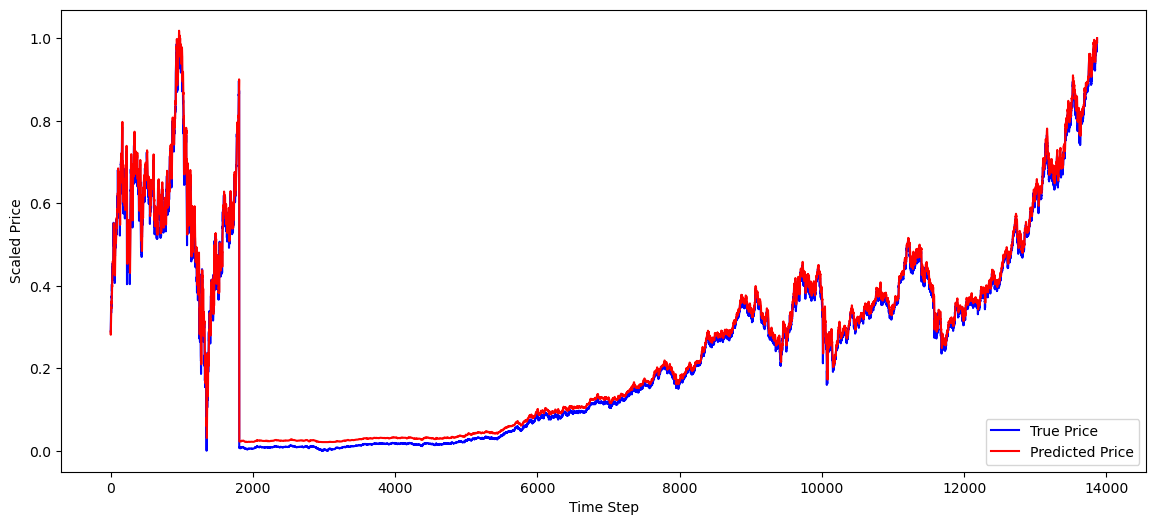

In [12]:
# Plot true vs predicted values for validation data
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_valid)), y_valid, label='True Price', color='blue')
plt.plot(range(len(y_valid_pred)), y_valid_pred, label='Predicted Price', color='red')
plt.xlabel("Time Step")
plt.ylabel("Scaled Price")
plt.legend()
plt.show()

In [ ]:
# Model 2
model_2 = Sequential()
model_2.add(SimpleRNN(32, input_shape=(lookback, 1)))  # Input shape specified here
model_2.add(Dense(1))
model_2.add(Activation('linear'))

model_2.compile(loss='mean_squared_error', optimizer='adam')

history_2 = model_2.fit(X_train, y_train, epochs=10, verbose=1)

# Predict and evaluate on validation data
y_valid_pred_2 = model_2.predict(X_valid)

# Calculate validation loss (RMSE)
validation_rmse_2 = np.sqrt(mean_squared_error(y_valid, y_valid_pred_2))
print(f"Model 2 - Validation RMSE: {validation_rmse_2}")


In [ ]:
# Model 3
model_3 = Sequential()
model_3.add(Reshape((lookback, 1), input_shape=(lookback,)))
model_3.add(Conv1D(3, 3, activation='relu'))
model_3.add(MaxPooling1D(3))
model_3.add(SimpleRNN(32))
model_3.add(Dropout(0.5))
model_3.add(Dense(1))
model_3.add(Activation('linear'))

model_3.compile(loss='mean_squared_error', optimizer='adam')

history_3= model_3.fit(X_train, y_train, epochs=10, verbose=1)

# Predict and evaluate on validation data
y_valid_pred_3 = model_3.predict(X_valid)

# Calculate validation loss (RMSE)
validation_rmse_3 = np.sqrt(mean_squared_error(y_valid, y_valid_pred_3))
print(f"Model 3 - Validation RMSE: {validation_rmse_3}")


In [ ]:
# Model 4
model_4 = Sequential()
model_4.add(Reshape((lookback, 1), input_shape=(lookback,)))
model_4.add(Conv1D(5, 5, activation='relu'))
model_4.add(MaxPooling1D(5))
model_4.add(SimpleRNN(64, return_sequences=True))
model_4.add(Dropout(0.5))
model_4.add(SimpleRNN(32, return_sequences=False))
model_4.add(Dropout(0.5))
model_4.add(Dense(1))
model_4.add(Activation('linear'))


model_4.compile(loss='mean_squared_error', optimizer='adam')

history_4= model_4.fit(X_train, y_train, epochs=10, verbose=1)

# Predict and evaluate on validation data
y_valid_pred_4 = model_4.predict(X_valid)

# Calculate validation loss (RMSE)
validation_rmse_4 = np.sqrt(mean_squared_error(y_valid, y_valid_pred_4))
print(f"Model 4 - Validation RMSE: {validation_rmse_4}")


## Testing with the Best Model

In [13]:
# Predict on test data
y_test_pred = model.predict(X_test)

# Calculate test loss (RMSE)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {test_rmse}")


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test RMSE: 0.021007255539198865


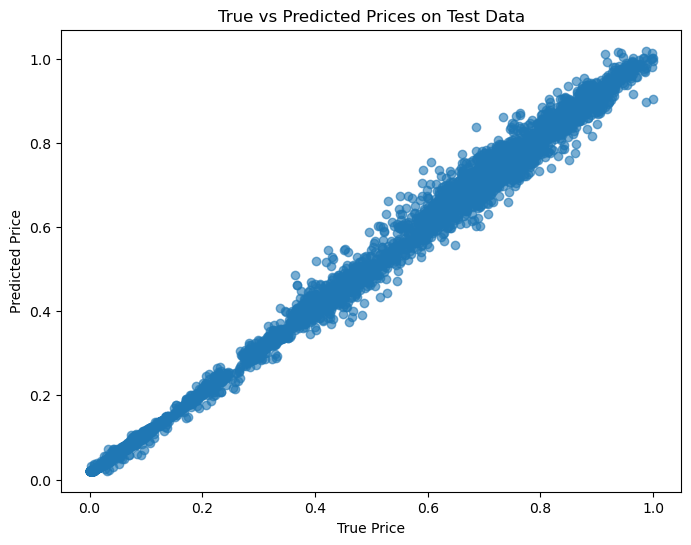

In [14]:
# Scatter plot of true vs predicted prices on test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted Prices on Test Data")
plt.show()

## Discussion and Justification

### Model Evaluation and Discussion
The best model was selected based on the lowest RMSE observed on the validation data. Model performance on both validation and test sets suggests it generalizes well, although there is some variability, likely due to stock price volatility. Based on RMSE values, the model can predict closing prices with a reasonably low error, making it a promising option for short-term stock price prediction, though it may require further tuning or more sophisticated methods to improve accuracy further.

### Future Considerations
Improving this model could involve experimenting with different lookback windows, tuning the Conv1D layer filters, or introducing additional layers like LSTM layers to capture more complex temporal dependencies in stock prices.